In [1]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, TextVectorization
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Neural Machine Translation 
Using a transformer model made from scratch using `Tensorflow` library tools.  
**Dataset**: English to French sentences. Can be find on kaggle through this [link](https://www.kaggle.com/datasets/devicharith/language-translation-englishfrench)  
We will focus on the `english -> french` direction only in this project.   

*Why **English** to **French**?*  
Because a speaker of both language - and luckily they're not LRLs - I can perform human evaluation myself to better assess the model behaviour later on
## Load the data
First step is to load the dataset, separate source and target sentences, clean and preprocess our data

In [2]:
dataset = pd.read_csv("data/eng_-french.csv")
dataset.head(20)

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !
5,Fire!,Au feu !
6,Help!,À l'aide !
7,Jump.,Saute.
8,Stop!,Ça suffit !
9,Stop!,Stop !


In [3]:
# separate source and target sentences 
english_sentences = list(dataset['English words/sentences'])
french_sentences = list(dataset['French words/sentences'])

print("Length of the dataset: ",len(dataset))

Length of the dataset:  175621


### Visualizations
We can visualize some things about our dataset mainly:
* Using a `word cloud` to visualize both vocabularies
* Using `box plot` to visualize sentence lengths

**Worclouds**  
Helps visualize the frequency of words in our vocab by giving them different sizes - the more frequent the bigger. This helps spot the most common words in a text or a language to have preview of their influence on your results if they appear in it

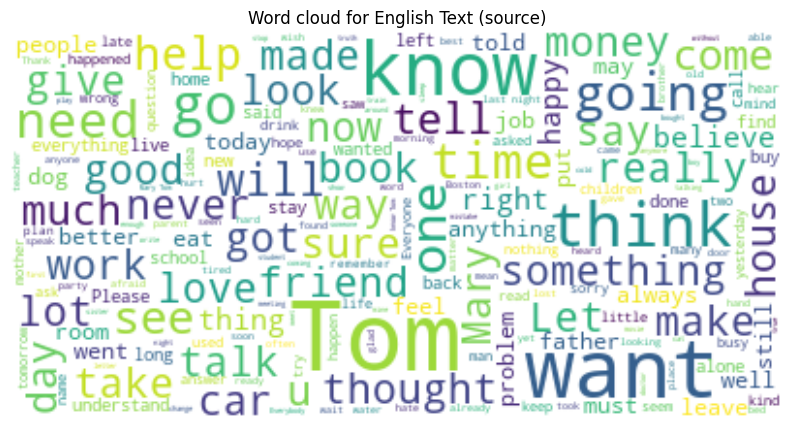

In [4]:
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white')
wordcloud = wordcloud.generate(str(english_sentences))

plt.figure(figsize=(10, 8))
plt.title("Word cloud for English Text (source)")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

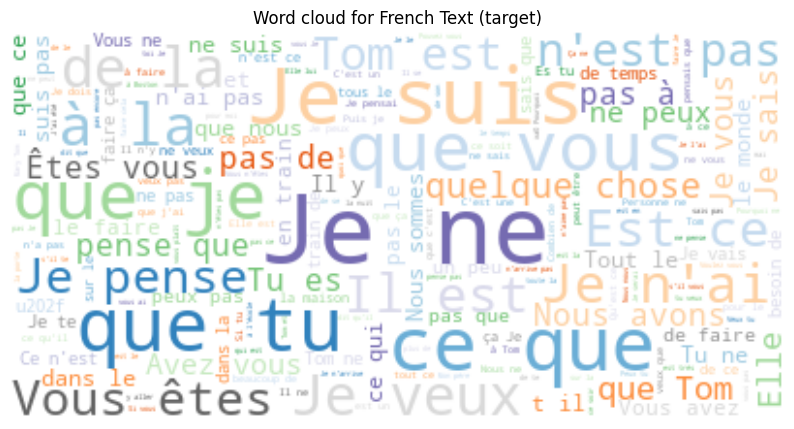

In [5]:
wordcloud = WordCloud(max_words=200, max_font_size=50, background_color='white', colormap='tab20c')
wordcloud = wordcloud.generate(str(french_sentences))

plt.figure(figsize=(10, 8))
plt.title("Word cloud for French Text (target)")
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

**Box Plot**  
We want to visualize sentence lengths in a box plot to know which length will be used to pad/or clip the other sentences to it as all sequences should have the same size

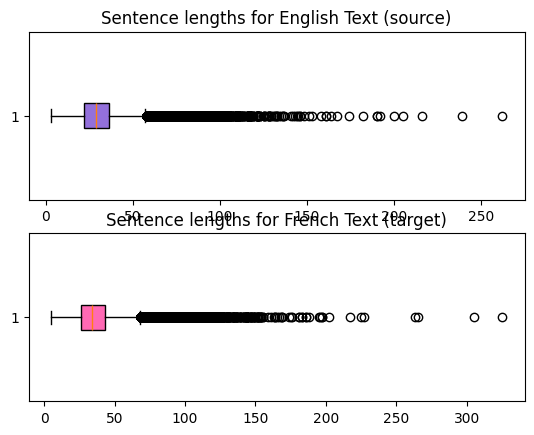

In [6]:
# visualizing box plot for source sentences
en_len = [len(english) for english in english_sentences]
plt.subplot(2, 1, 1)
#plt.figure(figsize=(8, 3))
plt.boxplot(en_len, vert=False, patch_artist=True, boxprops =dict(facecolor='mediumpurple'))
plt.title("Sentence lengths for English Text (source)")

# visualizing box plot for source sentences
fr_len = [len(french) for french in french_sentences]
plt.subplot(2, 1, 2)
#plt.figure(figsize=(8, 3))
plt.boxplot(fr_len, vert=False, patch_artist=True, boxprops =dict(facecolor='hotpink'))
plt.title("Sentence lengths for French Text (target)")

plt.show()

`Observation`  
We find that usually the french sentences are longer than the english 

### Text Preprocessing
Our dataset is mostly clean we just need to:
- Lowercase 
- Remove the punctuation (although sometimes it's important for the meaning but we'll remove this time for simplicity)
- Tokenize the words
- Add start of sentence -`sos` - and end of sentence - `eos` - tokens
- Add padding according to a predetermined `max_len`

#### French Specific Preprocessing 
- Separate words joined by `apostrophe` or `trait d'union`  

We will also create an *English* and *French* vocabulary

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [8]:
def clean_text(sentences, fr=False):
    """
    A method to apply preprocessing to a set of sentences
    
    Parameters:
    sentences (list or array-like sequence): senetnces to be cleaned and preprocessed
    fr (bool): to specify whether we apply the special french preprocessing or not

    Returns:
    clean_sentences (list or array-like sequence): set of tokenized and padded sequences
    vocab (dict): word to index dictionary containing the vocab and the respective index
    """
    # lowercase and add start and end tokens
    clean_sentences = ['sos '+ sentence.lower() +' eos' for sentence in sentences]
    # apply language-specific preprocessing
    if fr:
        # separate words joined by trait d'union and '
        clean_sentences = [re.sub(r"'|-",' ', sentence) for sentence in clean_sentences]
    
    # remove punctuation 
    clean_sentences = [re.sub(r'[^a-zA-Z\s]', "", sentence) for sentence in clean_sentences]

    return clean_sentences

def tokenize_sentence(sentences, max_len, tokenizer):
    # use the tokenizer on the texts
    sentences = tokenizer.texts_to_sequences(sentences)
    # padding the sequences to match in length
    sentences = pad_sequences(sentences, maxlen=max_len, padding='post', truncating='post')
    return sentences

# function to create and fit tokenizer to the corpus
def tokenize(sentences):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    return tokenizer

Now we apply the preprocessing functions to the dataset

In [9]:
max_len = 30
# clean the data
clean_en = clean_text(english_sentences)
clean_fr = clean_text(french_sentences, True)
# intialize the tokenizer for both languages
tokenizer_en = tokenize(clean_en)
tokenizer_fr = tokenize(clean_fr)
# use the initialized tokenizer to tokenize the sentences
tokenized_en = tokenize_sentence(clean_en, max_len, tokenizer_en)
tokenized_fr = tokenize_sentence(clean_fr, max_len, tokenizer_fr)

In [10]:
print("English:")
print(f"Before: {english_sentences[33]}\nAfter cleaning: {clean_en[33]}\nAfter tokenization{tokenized_en[33]}")

print("French:")
print(f"Before: {french_sentences[33]}\nAfter cleaning: {clean_fr[33]}\nAfter tokenization{tokenized_fr[33]}")

English:
Before: Go now.
After cleaning: sos go now eos
After tokenization[ 1 44 95  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]
French:
Before: Vas-y maintenant.
After cleaning: sos vas y maintenant eos
After tokenization[  1 322  36 139   2   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


In [11]:
# define vocab sizes for both languages 
vocab_size_en = len(tokenizer_en.word_index)+1
vocab_size_fr = len(tokenizer_fr.word_index)+1

print(f"english vocab size {vocab_size_en}")
print(f"french vocab size {vocab_size_fr}")

english vocab size 14412
french vocab size 26429


## Model Architecture
### Train/test split 
20% testing and the rest is for training

In [12]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(tokenized_en, tokenized_fr, test_size=0.2, random_state=42)

print(f"Shape of train_x: {train_x.shape}")
print(f"Shape of train_y: {train_y.shape}")

print(f"Shape of test_x: {test_x.shape}")
print(f"Shape of test_y: {test_y.shape}")

Shape of train_x: (140496, 30)
Shape of train_y: (140496, 30)
Shape of test_x: (35125, 30)
Shape of test_y: (35125, 30)


defining the model architecture:  
- Embedding layer
- 2 LSTM layers with 512 each
- a repeat vector layer which helps remember the input from a few timesteps back minimizing info loss
- output layer with softmax activation

In [13]:
from tensorflow.keras.mixed_precision import set_global_policy

set_global_policy('mixed_float16')

In [14]:
def build_model(input_vocab_size, output_vocab_size, max_len, units):
    # define the model 
    model = Sequential()
    # add embedding layer with embedding size = units
    model.add(Embedding(
        input_vocab_size,
        units,
        input_length = max_len,
        mask_zero = True
    ))
    # add LSTM layer 
    model.add(LSTM(units))
    # add repeat vector layer to minimize info loss as much as possible
    model.add(RepeatVector(max_len))
    # add another LSTM layer
    model.add(LSTM(units, return_sequences=True))
    # output layer
    model.add(Dense(output_vocab_size, activation='softmax'))
    
    return model 

In [15]:
# initialize and compile the model 
model = build_model(vocab_size_en, vocab_size_fr, max_len, 128)
# define optimizer
optimizer = optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

model.build(input_shape=(None, max_len))  # Specify input shape explicitly
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 30, 128)             │       1,844,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 128)             │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30, 26429)           │       3,409,341 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,517,245 (21.05 MB)

 Trainable params: 5,517,245 (21.05 MB)

 Non-trainable params: 0 (0.00 B)

### Fit the model
`ModelCheckpoint()` function saves the model with the lowest validation loss

In [16]:
# filename to save the model to
filename = 'model.keras'
#initialize model checkpoint
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train the model
history = model.fit(train_x, train_y.reshape(train_y.shape[0], train_y.shape[1], 1), epochs=10, batch_size=16, validation_split=0.2, callbacks=[checkpoint], verbose=1)

Epoch 1/10
7024/7025 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.9832
Epoch 1: val_loss improved from inf to 1.37366, saving model to model.keras
7025/7025 ━━━━━━━━━━━━━━━━━━━━ 196s 27ms/step - loss: 1.9831 - val_loss: 1.3737
Epoch 2/10
7023/7025 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2999
Epoch 2: val_loss improved from 1.37366 to 1.15543, saving model to model.keras
7025/7025 ━━━━━━━━━━━━━━━━━━━━ 190s 27ms/step - loss: 1.2999 - val_loss: 1.1554
Epoch 3/10
7024/7025 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0846
Epoch 3: val_loss improved from 1.15543 to 1.02764, saving model to model.keras
7025/7025 ━━━━━━━━━━━━━━━━━━━━ 191s 27ms/step - loss: 1.0846 - val_loss: 1.0276
Epoch 4/10
7023/7025 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.8445
Epoch 5: val_loss improved from 0.94986 to 0.90776, saving model to model.keras
7025/7025 ━━━━━━━━━━━━━━━━━━━━ 190s 27ms/step - loss: 0.8445 - val_loss: 0.9078
Epoch 6/10
7024/7025 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.7756
Epoch 6: val_l

### Plotting the train and validation losses

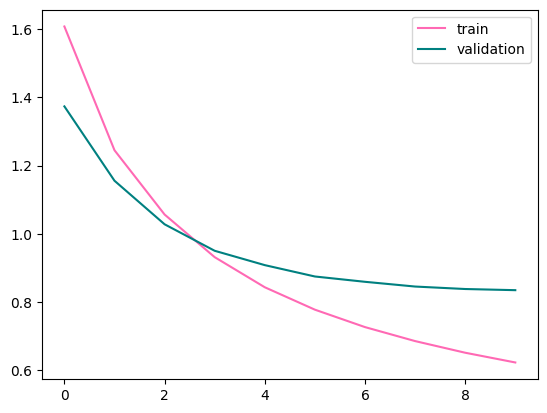

In [17]:
plt.plot(history.history['loss'], color='hotpink')
plt.plot(history.history['val_loss'], color='teal')
plt.legend(['train','validation'])
plt.show()

## Predicting on new data
Now we load the model weights and test the model on the test set

In [14]:
loaded_model = load_model("model.keras")
predictions = loaded_model.predict(test_x[:1000].reshape((test_x[:1000].shape[0], test_y[:1000].shape[1])))

32/32 ━━━━━━━━━━━━━━━━━━━━ 133s 4s/step


In [15]:
logits = np.copy(predictions)
predictions = []
# get the index of each word instead of the logits
for i, pred in enumerate(logits):
    temp = []
    for word_probs in pred:
        temp.append(np.argmax(word_probs))
    predictions.append(temp)


Decoding each predicted word into a word to form the translated sentence, and for that we create a number of different helper methods:  
- `get_word()` convert the index to word

In [16]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return 'unk'

# prediction loop on test set 
predicted_sentences = []
# decode the predictions in the predictions set
for pred in predictions:
    # temporary array to store the decoded text from the prediction
    temp = []
    # loop through each token in the predicted sentence
    for i in range(len(pred)):
        # get the word from the target (french) vocab
        word = get_word(pred[i], tokenizer_fr)
        if i > 0:
            # removing the padding
            if (word == get_word(pred[i-1], tokenizer_en)) or (word == None):
                temp.append("")
            else:
                temp.append(word)
        else:
            if word == 'unk':
                temp.append("")
            else:
                temp.append(word)
    predicted_sentences.append(" ".join(temp))

### Calculating the BLEU score 
Now it's time to compare the predicted values with the the original text

In [23]:
# decode the test set 
source_test = []
target_test = []

for source, target in zip(test_x[:1000], test_y[:1000]):
    temp_s = []
    temp_t = []
    # decode source sentence
    for i in range(len(source)):
        word = get_word(source[i], tokenizer_en)
        # removing the padding
        if (word == get_word(source[i-1], tokenizer_en)) or (word == None):
            temp.append("")
        else:
            temp_s.append(word)

    # decode target sentence
    for i in range(len(target)):
        word = get_word(target[i], tokenizer_fr)
        if (word == get_word(target[i-1], tokenizer_fr)) or (word == None):
            temp.append("")
        else:
            temp_t.append(word)

    # append decoded sentences to the list
    source_test.append(" ".join(temp_s))
    target_test.append(" ".join(temp_t))

In [24]:
# put source, actual and predictions in a dataframe
compare_df = pd.DataFrame({'English': source_test, "French": target_test, "Prediction": predicted_sentences})
compare_df.head(15)

,English,French,Prediction
0,sos take a seat eos unk,sos prends place eos unk,sos assieds toi eos unk
1,sos i wish tom was here eos unk,sos j aimerais que tom soit l eos unk,sos j aimerais que tom tait ici eos unk ...
2,sos how did the audition go eos unk,sos comment s est passe l audition eos unk,sos comment s a pass il eos unk ...
3,sos ive no friend to talk to about my problems...,sos je n ai pas d ami avec lequel je puisse m ...,sos je n ai pas de avoir mes mes mes eos unk ...
4,sos i really like this skirt can i try it on e...,sos j aime beaucoup cette jupe puis je l essay...,sos j espre vraiment que je je essayer essayer...
5,sos what happened to him eos unk,sos que lui est il arriv eos unk,sos qu est il arriv il eos unk ...
6,sos take any two cards you like eos unk,sos prends deux cartes de ton choix eos unk,sos prenez de de de de vous eos unk ...
7,sos im not scared to die eos unk,sos je ne crains pas de mourir eos unk,sos je n ai pas peur de mourir eos unk ...
8,sos the clock has stopped eos unk,sos l horloge s est arrte eos unk,sos le tlphone s arrta arrt eos unk ...
9,sos youd better make sure that it is true eos unk,sos tu ferais bien de t assurer que c est vrai...,sos tu ferais mieux de que que est est est est...


Now that we have everything decoded we do the evaluation loop on 1000 samples of the test set as it's very large

In [25]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
def evaluate(actual, predictions):
    avg_bleu = 0
    for ref, pred in zip(actual, predictions):
        # convert the sentence from a string to a list of words
        ref = [ref.split(" ")]
        pred = pred.split(" ")
        # compute bleu score
        avg_bleu += sentence_bleu(ref, pred)
        
    return avg_bleu/len(actual)

BLEU = evaluate(target_test, predicted_sentences)
print("BLEU Score: ", BLEU)

BLEU Score:  0.04715032632580635


C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using 

Even though the bleu score is low, the predictions make a lot of sense and since it measures overlapping words sometimes we can reach the same meaning with different words so the human evaluation in our case is better, and i say it's a very impressive results, sometimes the prediction - in my opinion - is better than the original sentence